In [47]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [48]:
az.style.use("arviz-whitegrid")
plt.rc('figure', dpi=450)

In [49]:
tips = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data//tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


Text(0, 0.5, 'Day')

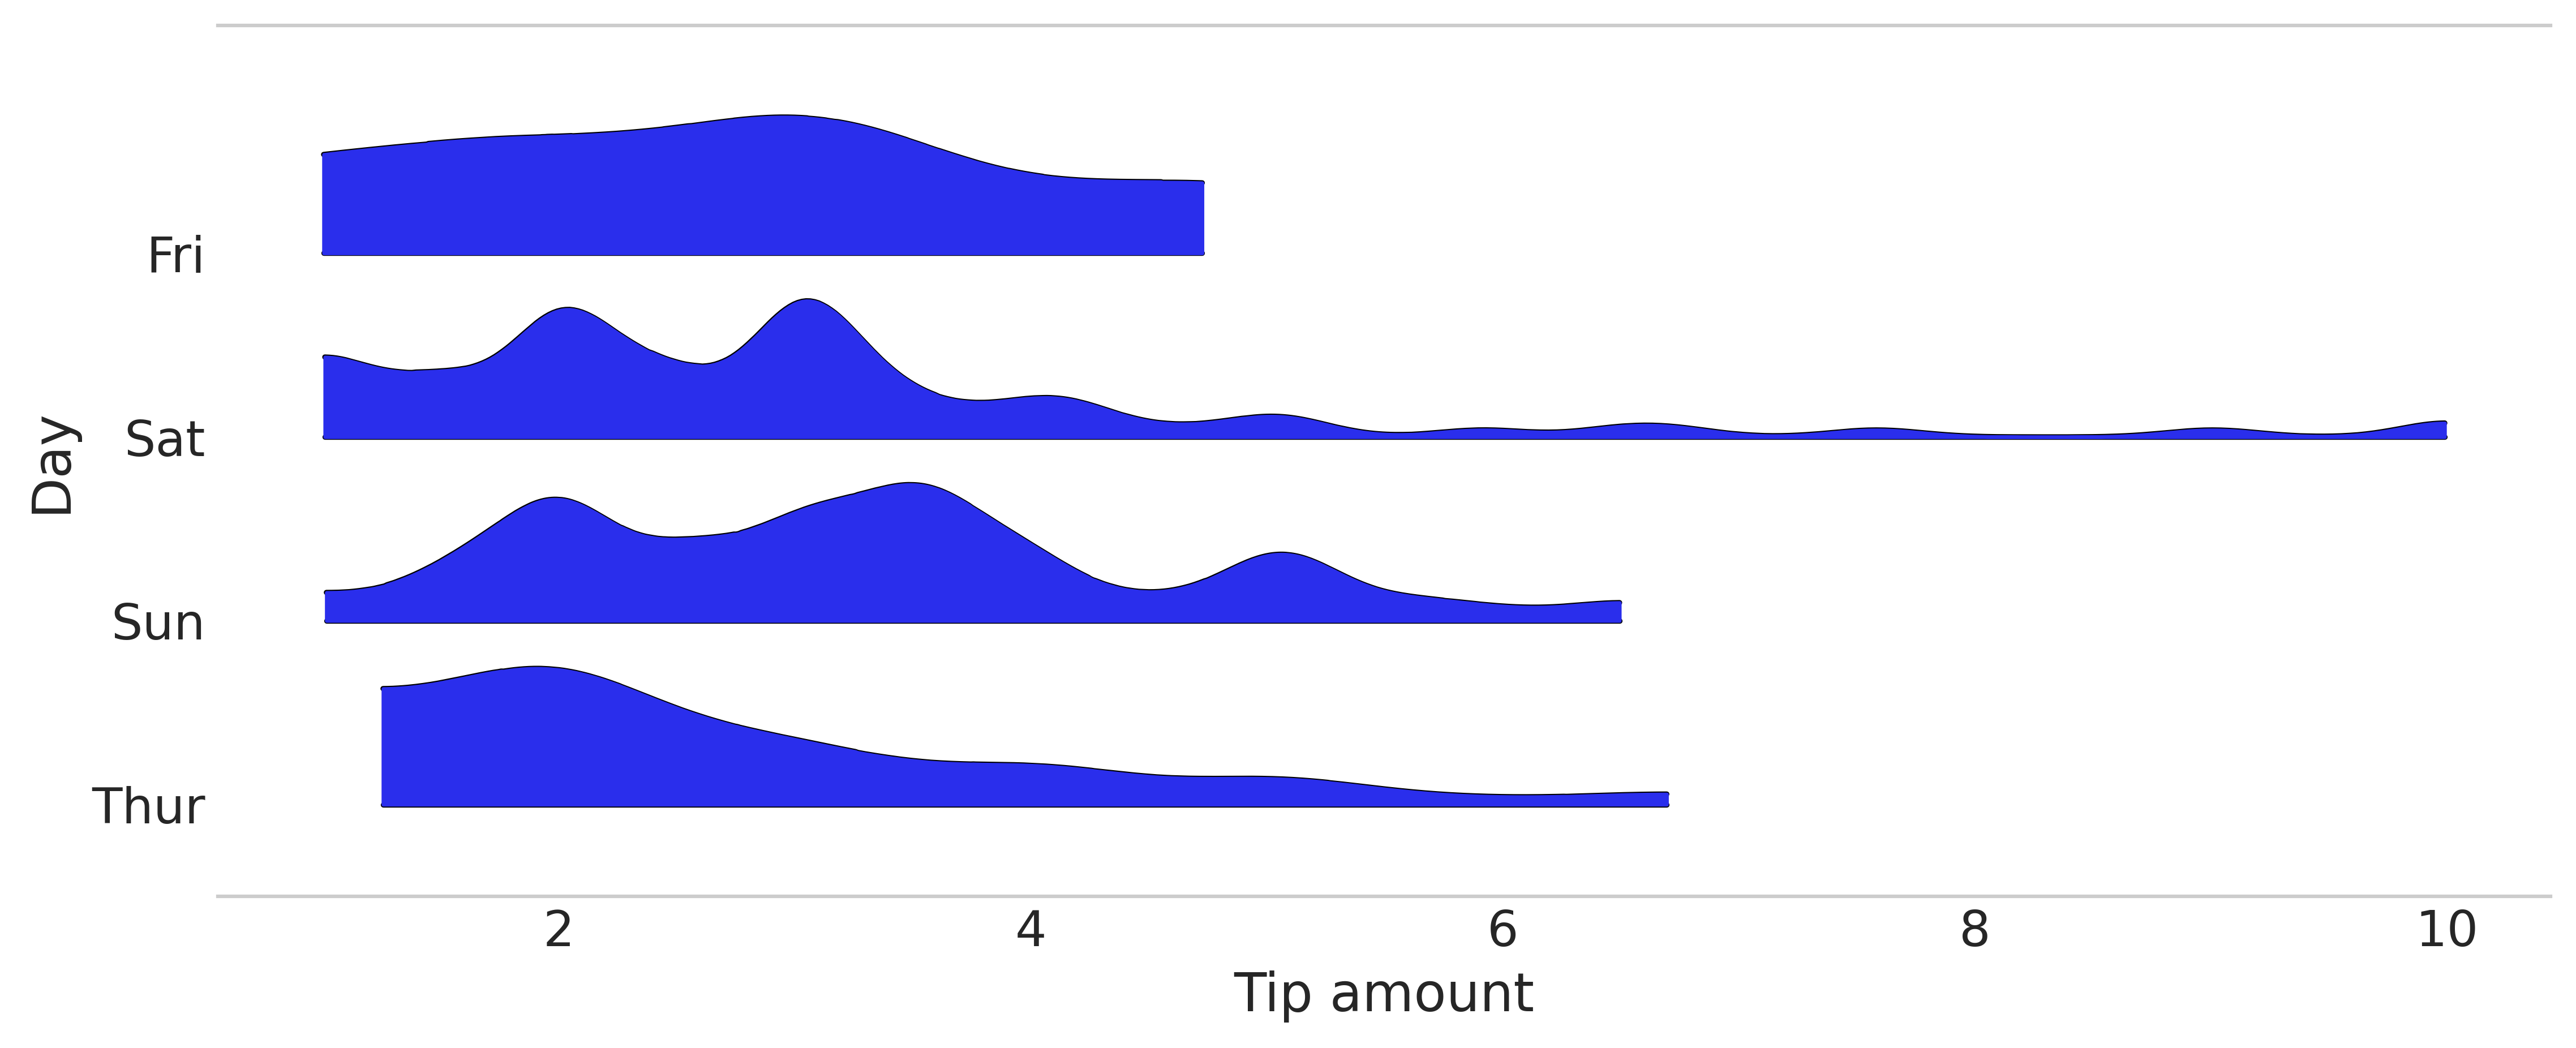

In [50]:
_, ax = plt.subplots(figsize=(10, 4))
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               ax=ax)
ax.set_xlabel("Tip amount")
ax.set_ylabel("Day")

In [51]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [52]:
pooled_coords = {"data": np.arange(len(tip))}

σ_μ = 5
σ_σ = 1

with pm.Model(coords=pooled_coords) as pooled_model:
    μ = pm.HalfNormal("μ", sigma=σ_μ)
    σ = pm.HalfNormal("σ", sigma=σ_σ)

    y = pm.Gamma("y", mu=μ, sigma=σ, observed=tip, dims="data")


unpooled_coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=unpooled_coords) as unpooled_model:
    μ = pm.HalfNormal("μ", sigma=σ_μ, dims="days")
    σ = pm.HalfNormal("σ", sigma=σ_σ, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

models = {"pooled": pooled_model, "unpooled": unpooled_model}

In [53]:
idatas = {}
for model_name, model in models.items():
    with model:
        idata = pm.sample(2000, tune=1000)
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)
        idatas[model_name] = idata



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [y]


Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.
Sampling: [y]


Output()

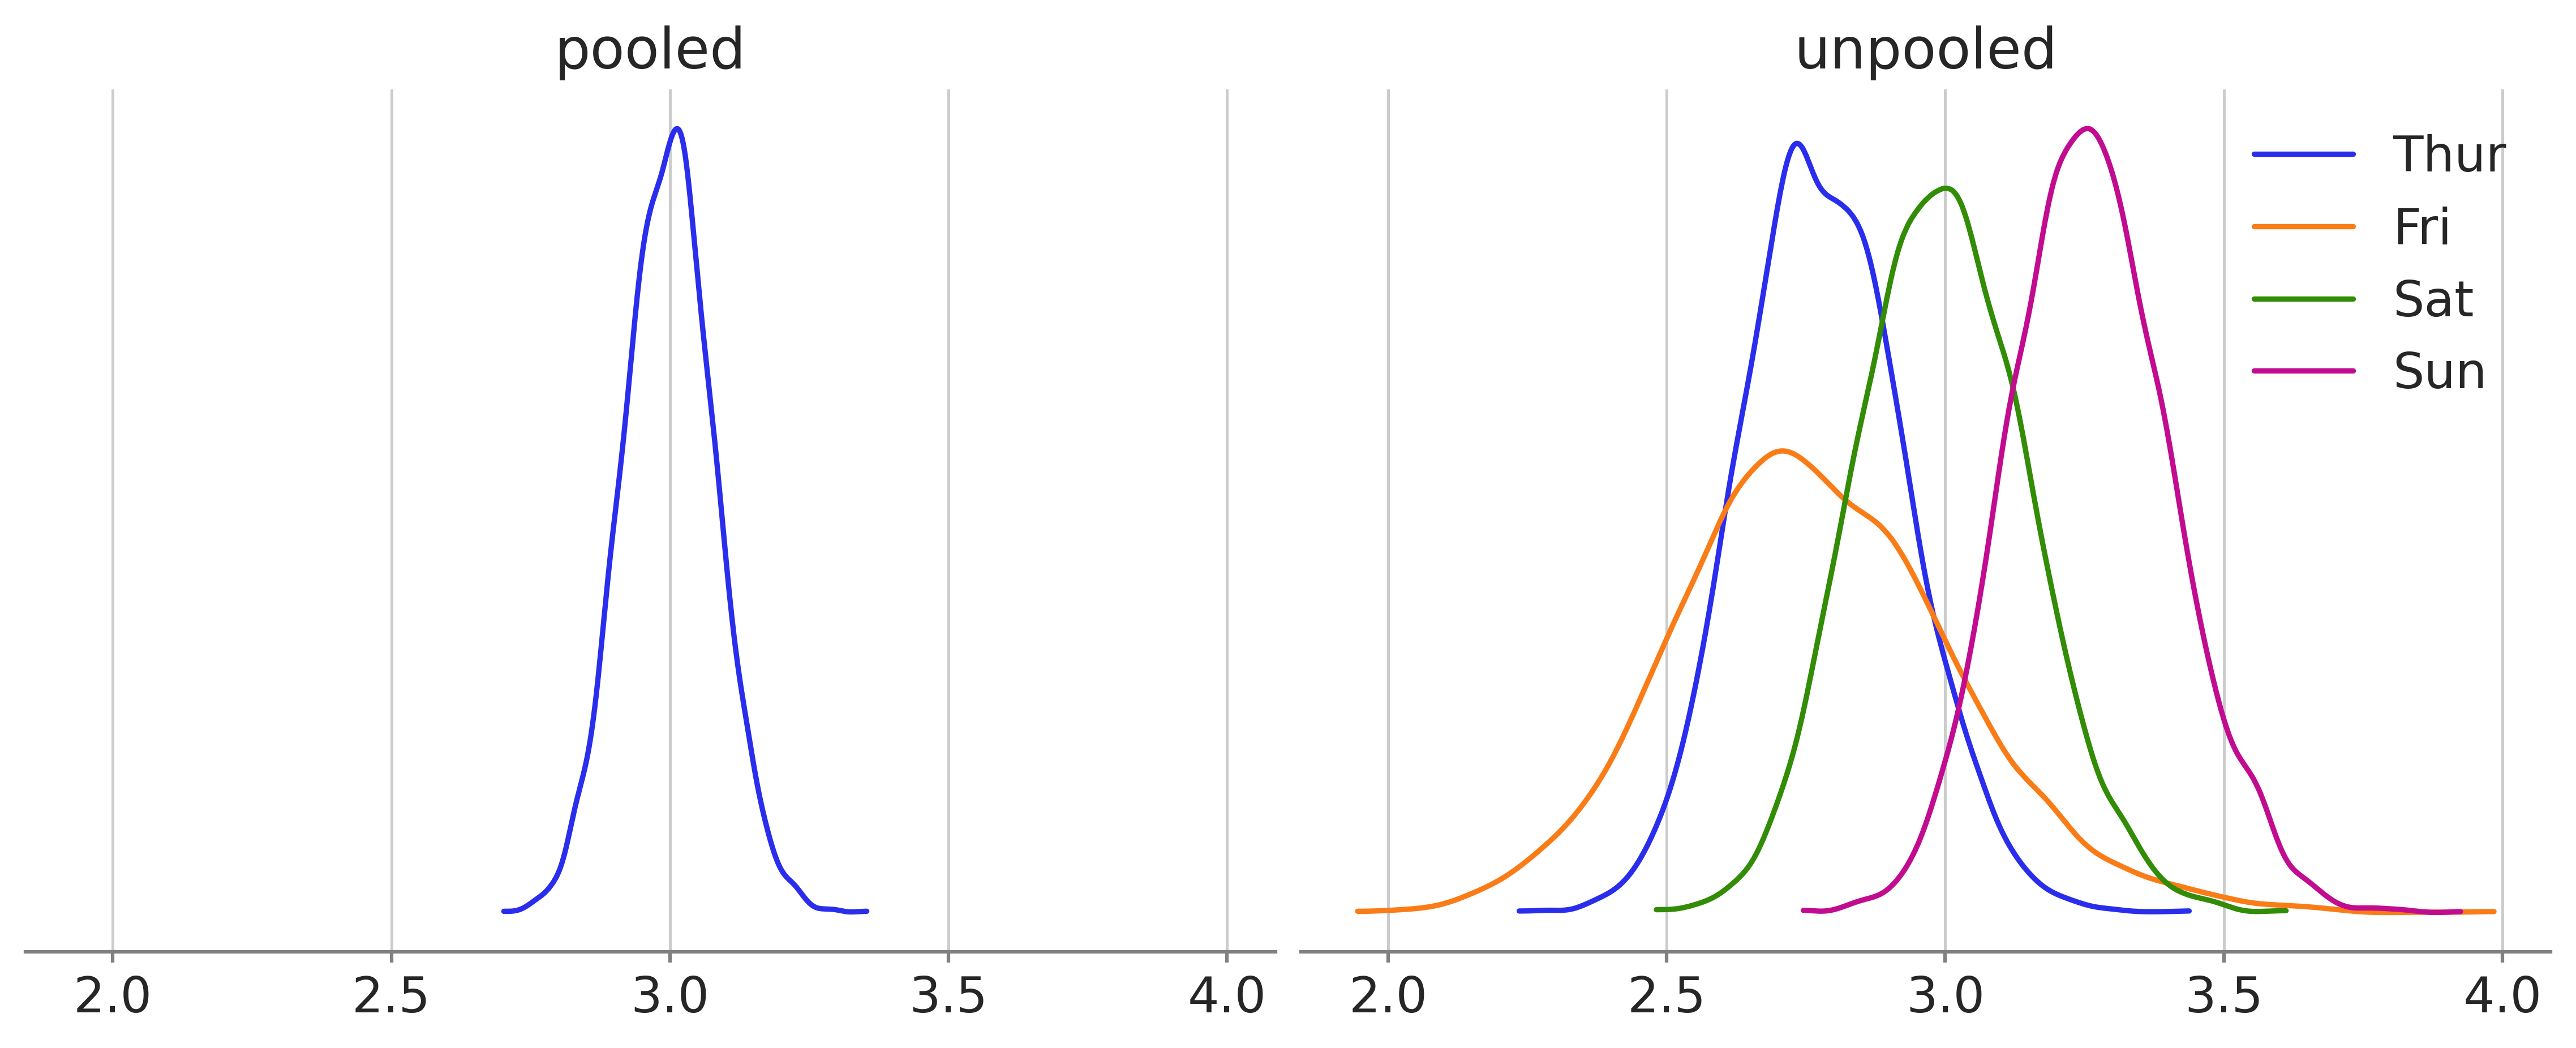

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i, (model_name, idata) in enumerate(idatas.items()):
    if model_name == "pooled":
        pm.plot_posterior(idata, var_names=["μ", "σ"], ax=ax[i], hdi_prob='hide', point_estimate=None)
    else:
        for j,day in enumerate(categories):
            pm.plot_posterior(idata, var_names=["μ", "σ"], hdi_prob='hide', point_estimate=None,
                              color=f"C{j}", coords={"days": day}, label=f'{day}', 
                              ax=ax[i])
        ax[i].legend()
    ax[i].set_title(model_name)
plt.show()


<Axes: title={'center': 'μ'}>

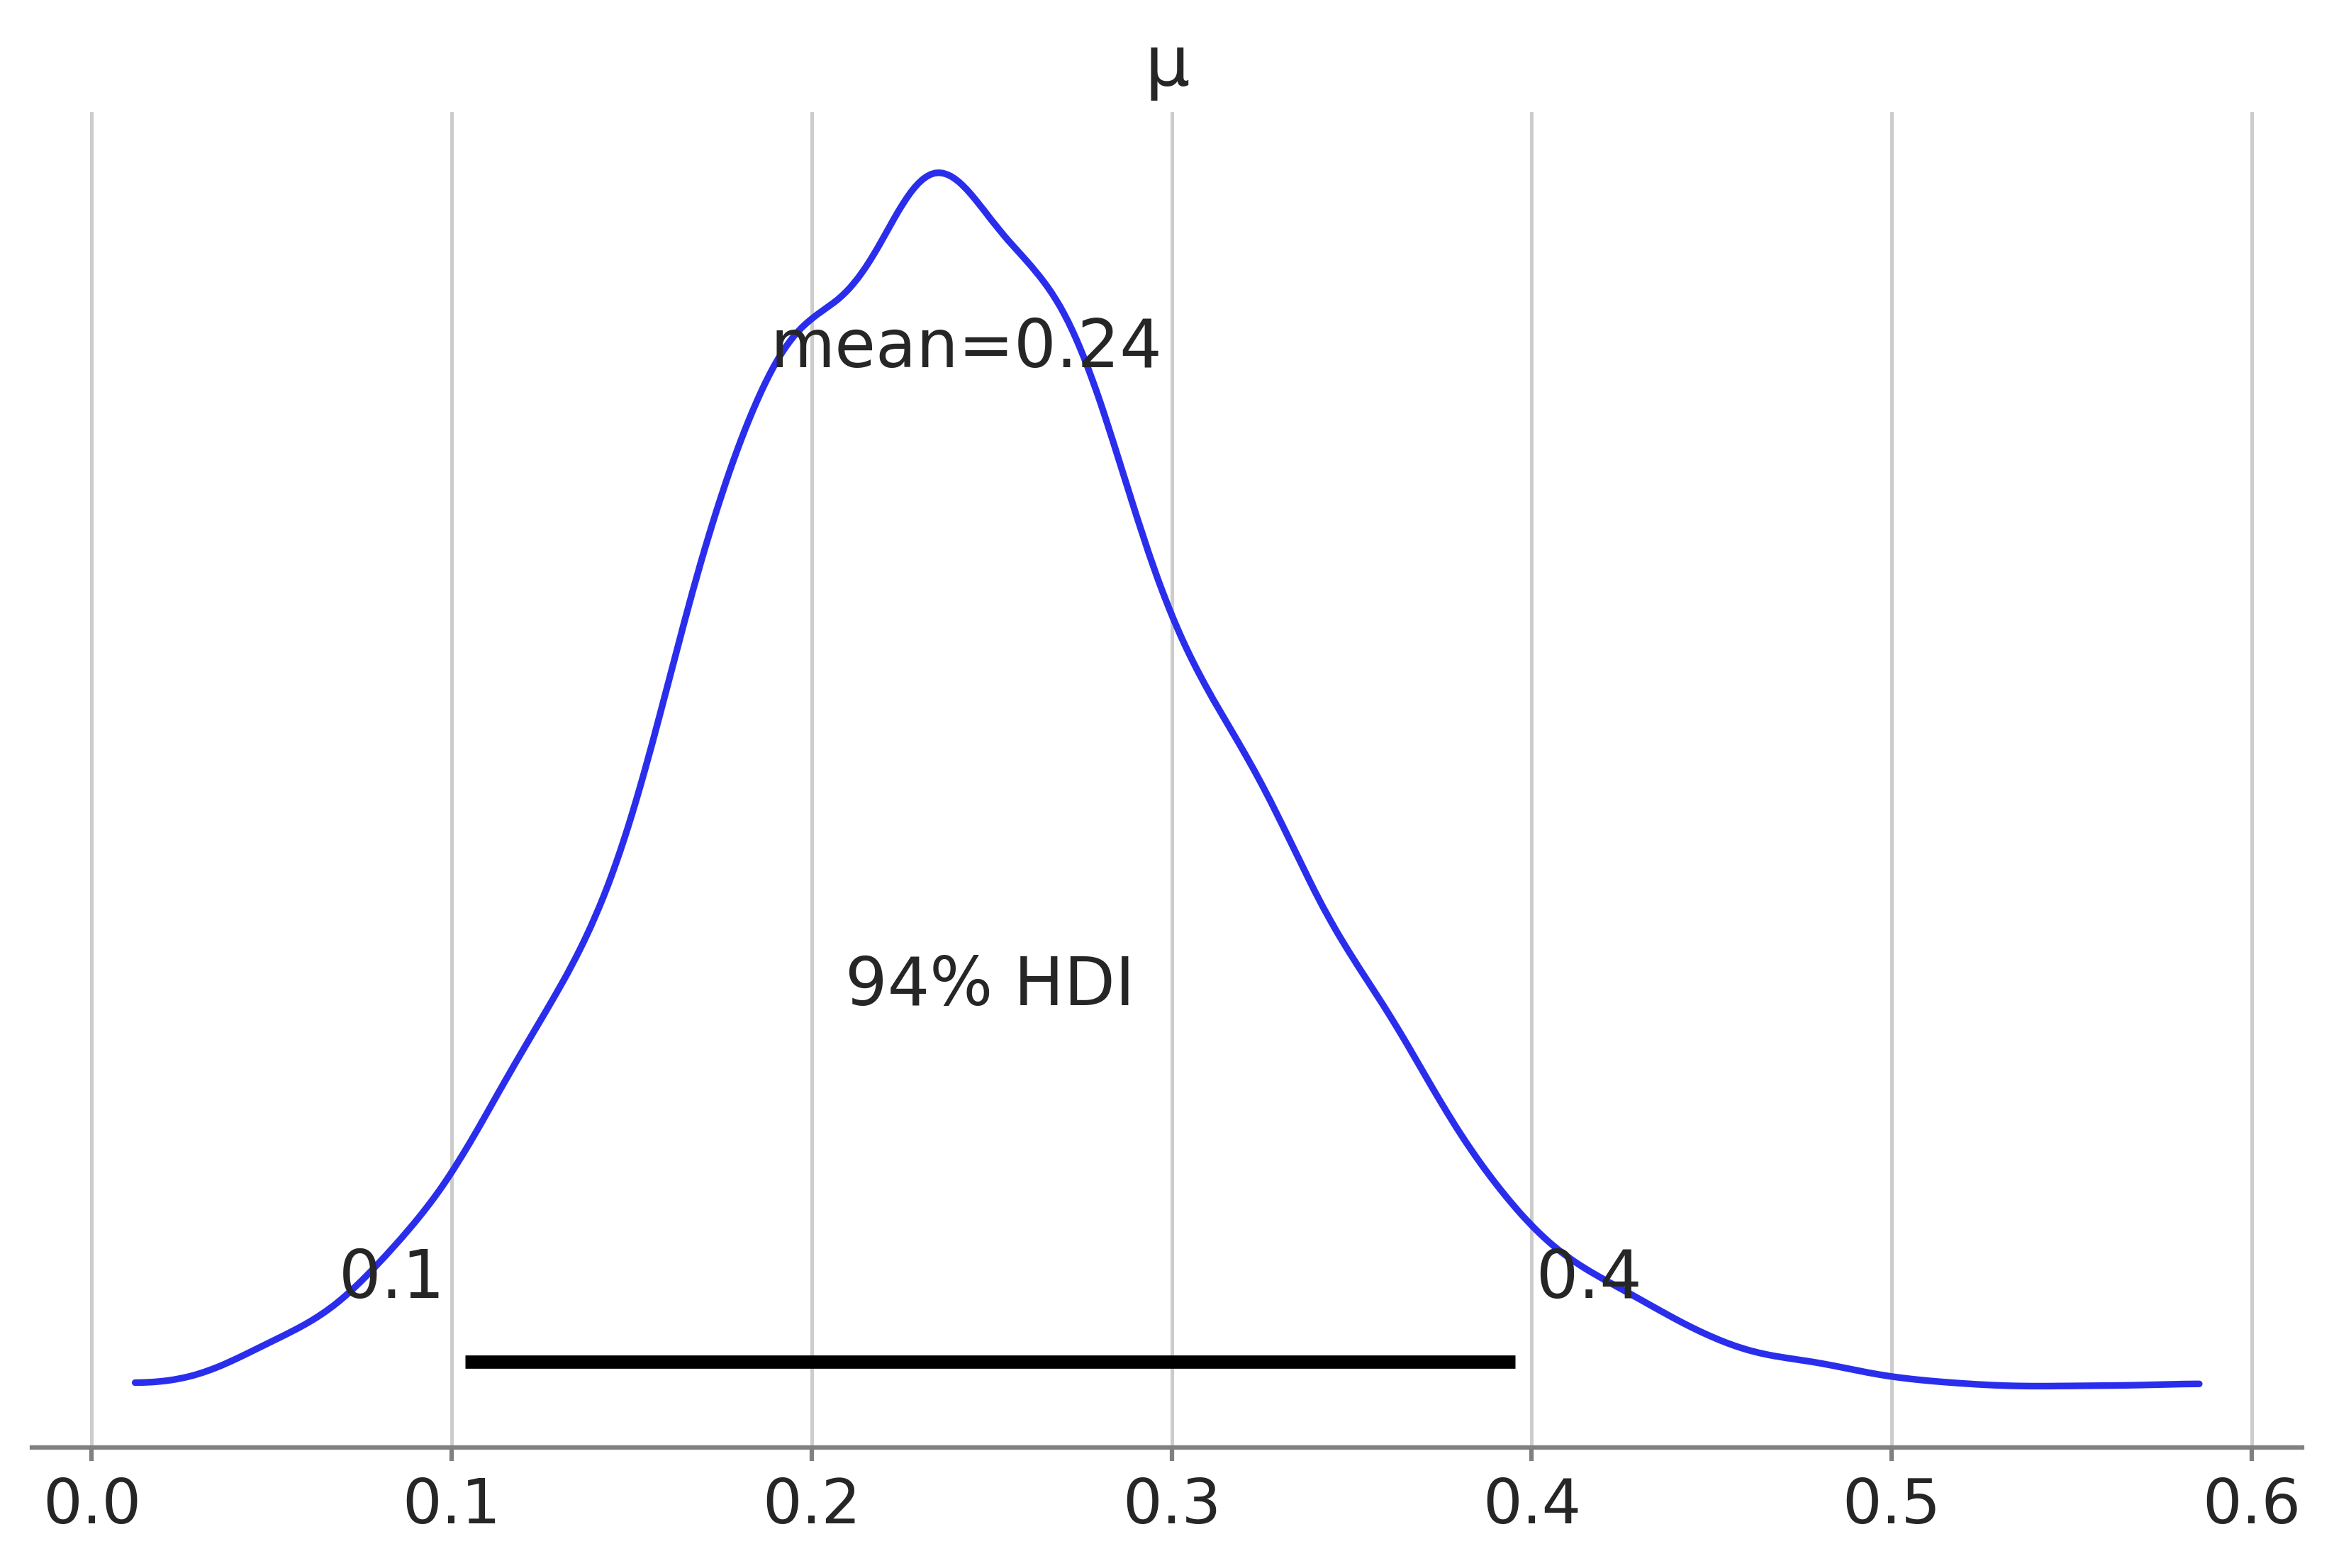

In [55]:
mu = idatas["unpooled"].posterior["μ"]
az.plot_posterior(mu.std(dim="days"))

mu_mu: mean: 2.424196969171701, std: 0.7914768209501252


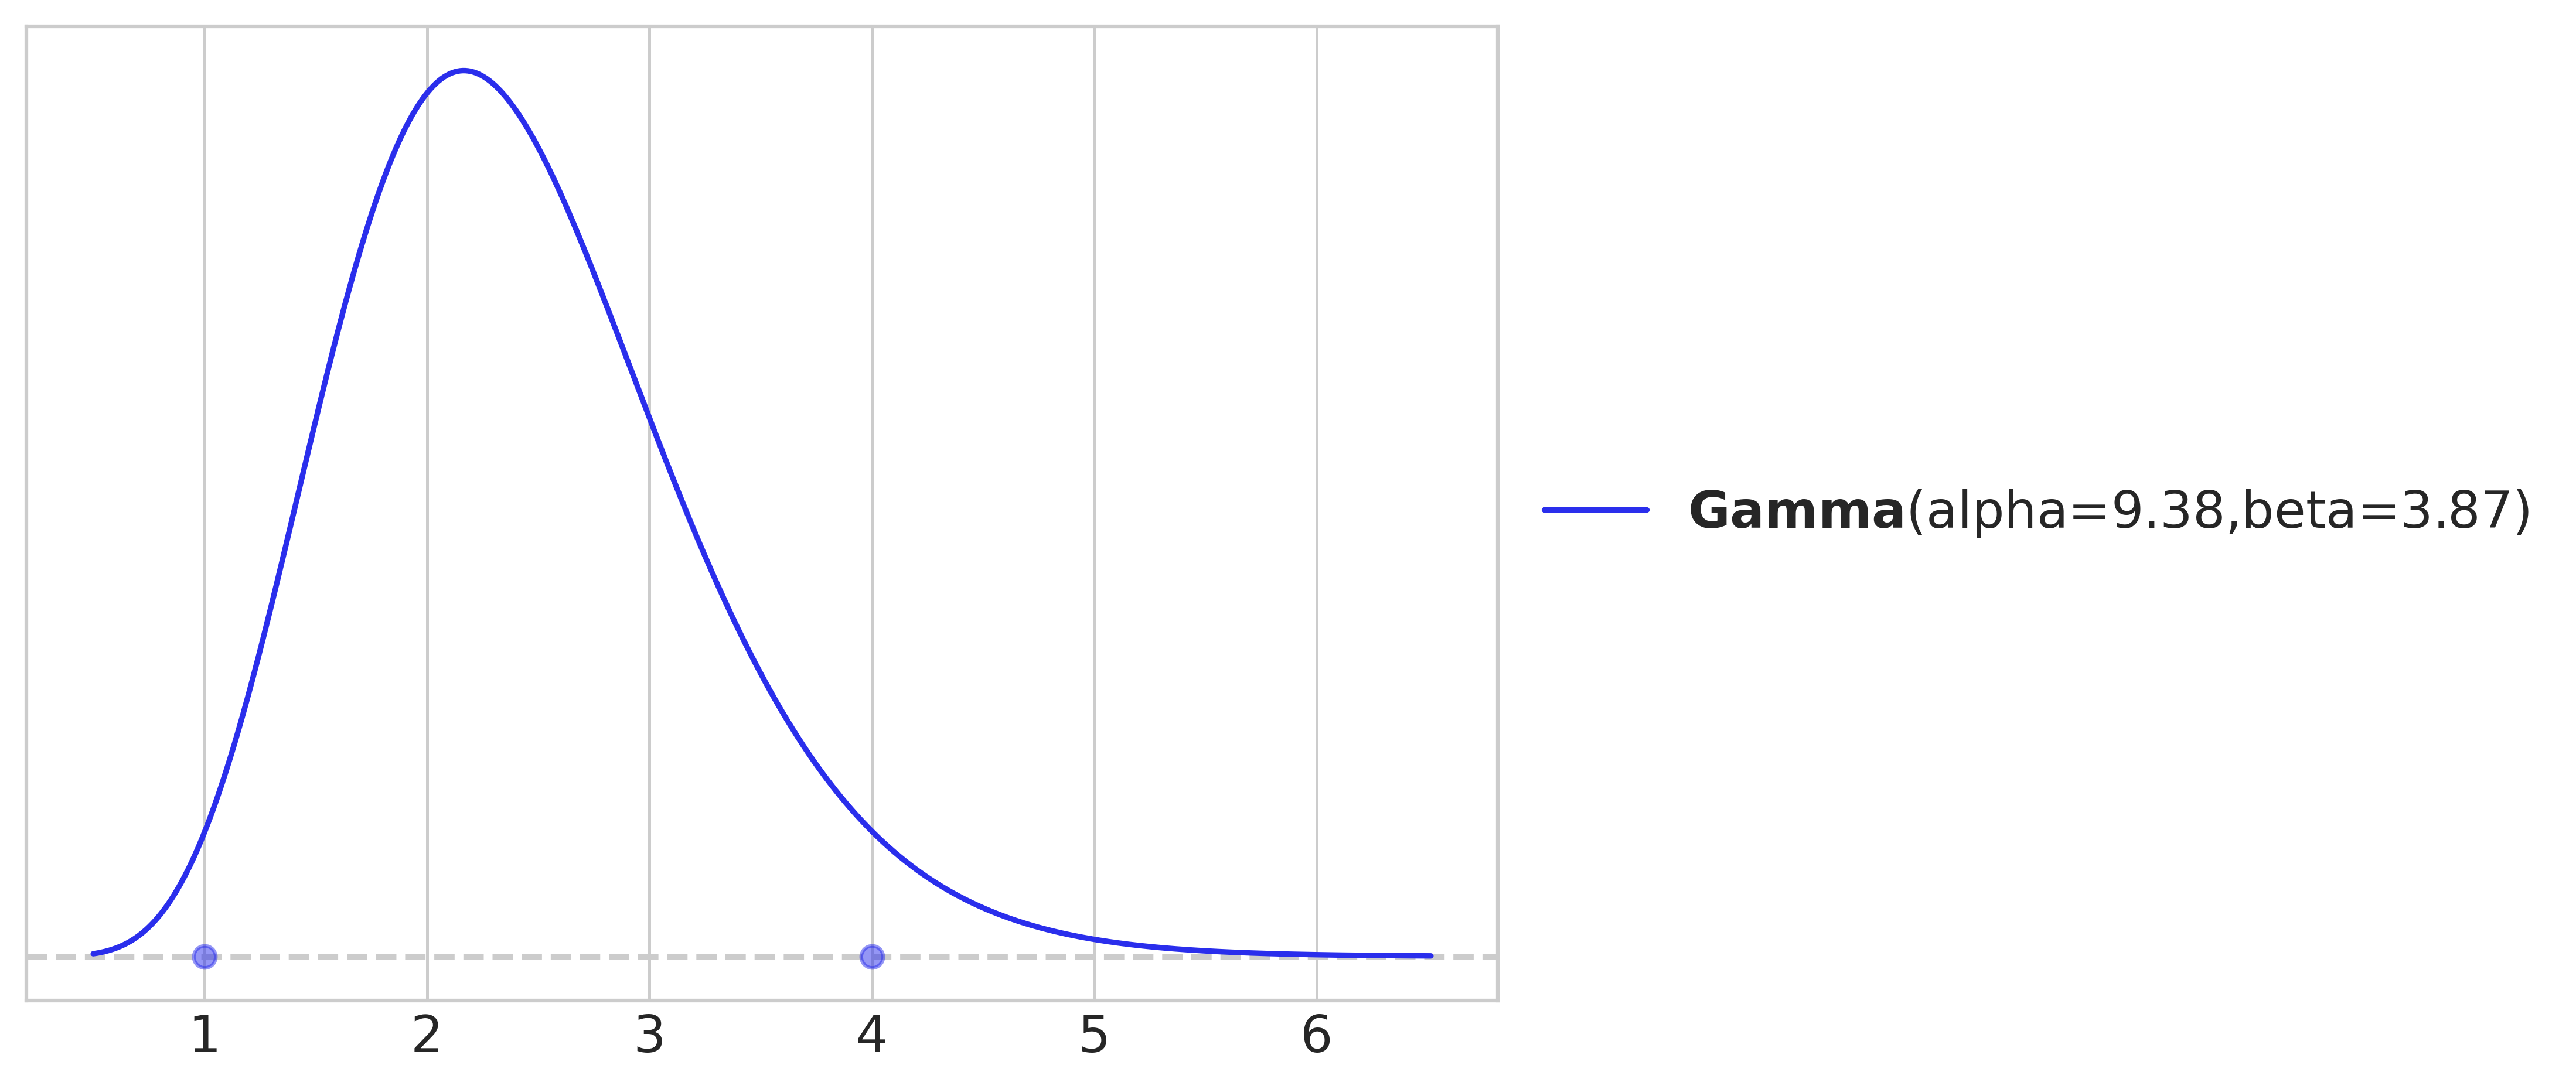

In [56]:
gma = pz.Gamma()
pz.maxent(gma, lower=1, upper=4, mass=0.95)
print(f"mu_mu: mean: {gma.mean()}, std: {gma.std()}")

mu_mu: mean: 0.22464897165950165, std: 0.14204033992030463


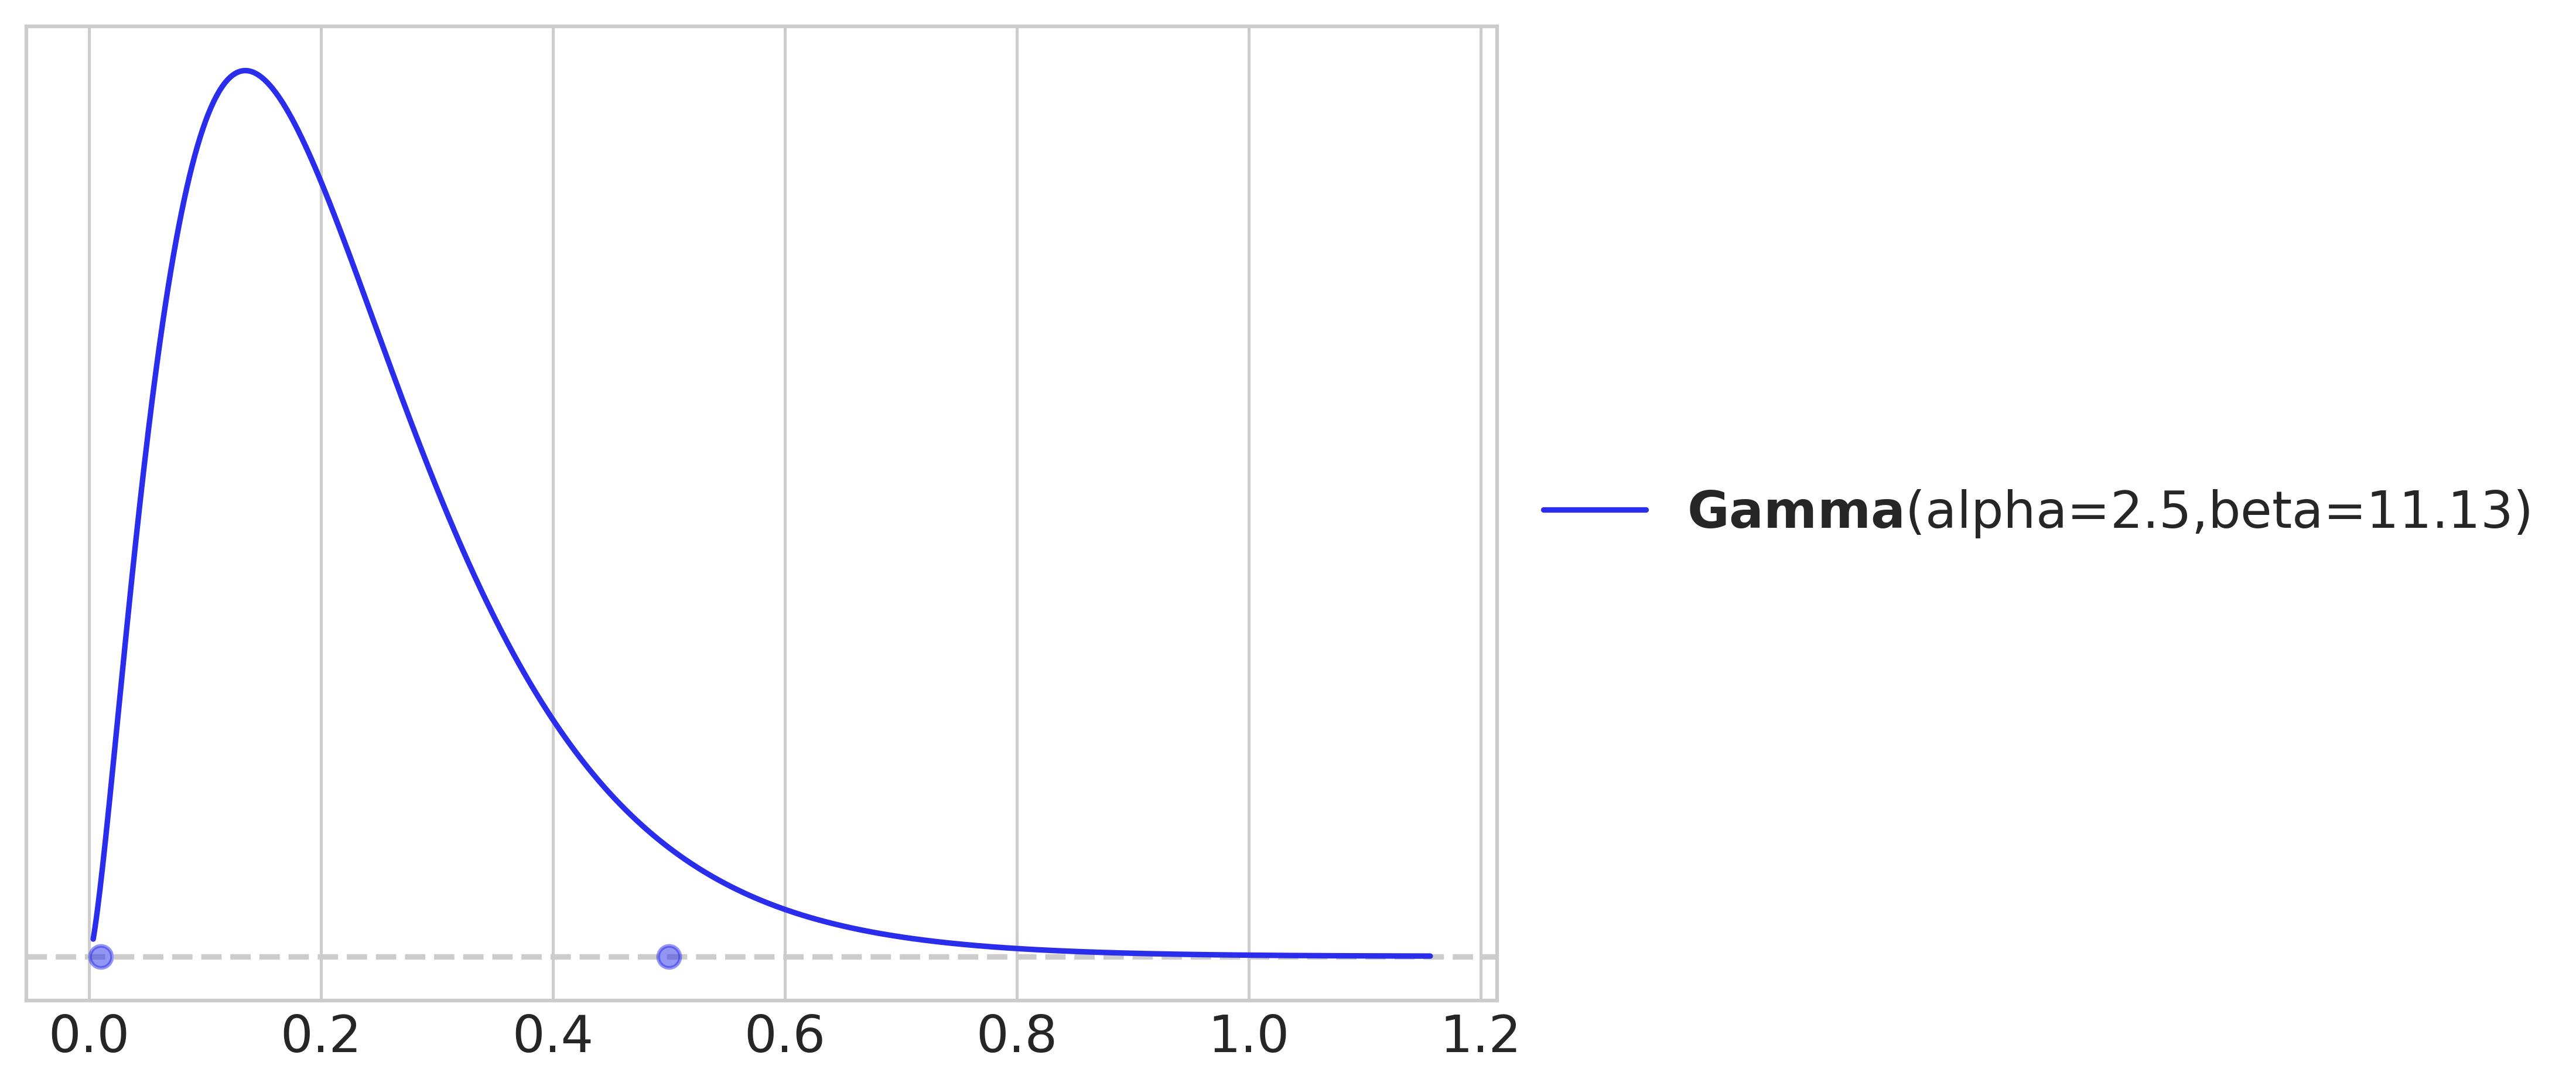

In [57]:
gma = pz.Gamma()
pz.maxent(gma, lower=0.01, upper=0.5, mass=0.95)
print(f"mu_mu: mean: {gma.mean()}, std: {gma.std()}")

In [58]:
partial_pooling_coords = {"days": categories, "days_flat":categories[idx]}

μ_μμ = 2.5
σ_μμ = 0.8
μ_σμ = 0.22
σ_σμ = 0.14

with pm.Model(coords=partial_pooling_coords) as partial_pooling_model:
    μ_μ = pm.Gamma("μ_μ", mu=μ_μμ, sigma=σ_μμ)
    σ_μ = pm.Gamma("σ_μ", mu=μ_σμ, sigma=σ_σμ)
    
    μ = pm.Gamma("μ", mu=μ_μ, sigma=σ_μ, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

models = {"pooled": pooled_model, "unpooled": unpooled_model, "partial pooling": partial_pooling_model}

In [59]:
with partial_pooling_model:
    idata = pm.sample(2000, tune=2000, nuts={'target_accept': 0.99})
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
idatas["partial pooling"] = idata

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_μ, σ_μ, μ, σ]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

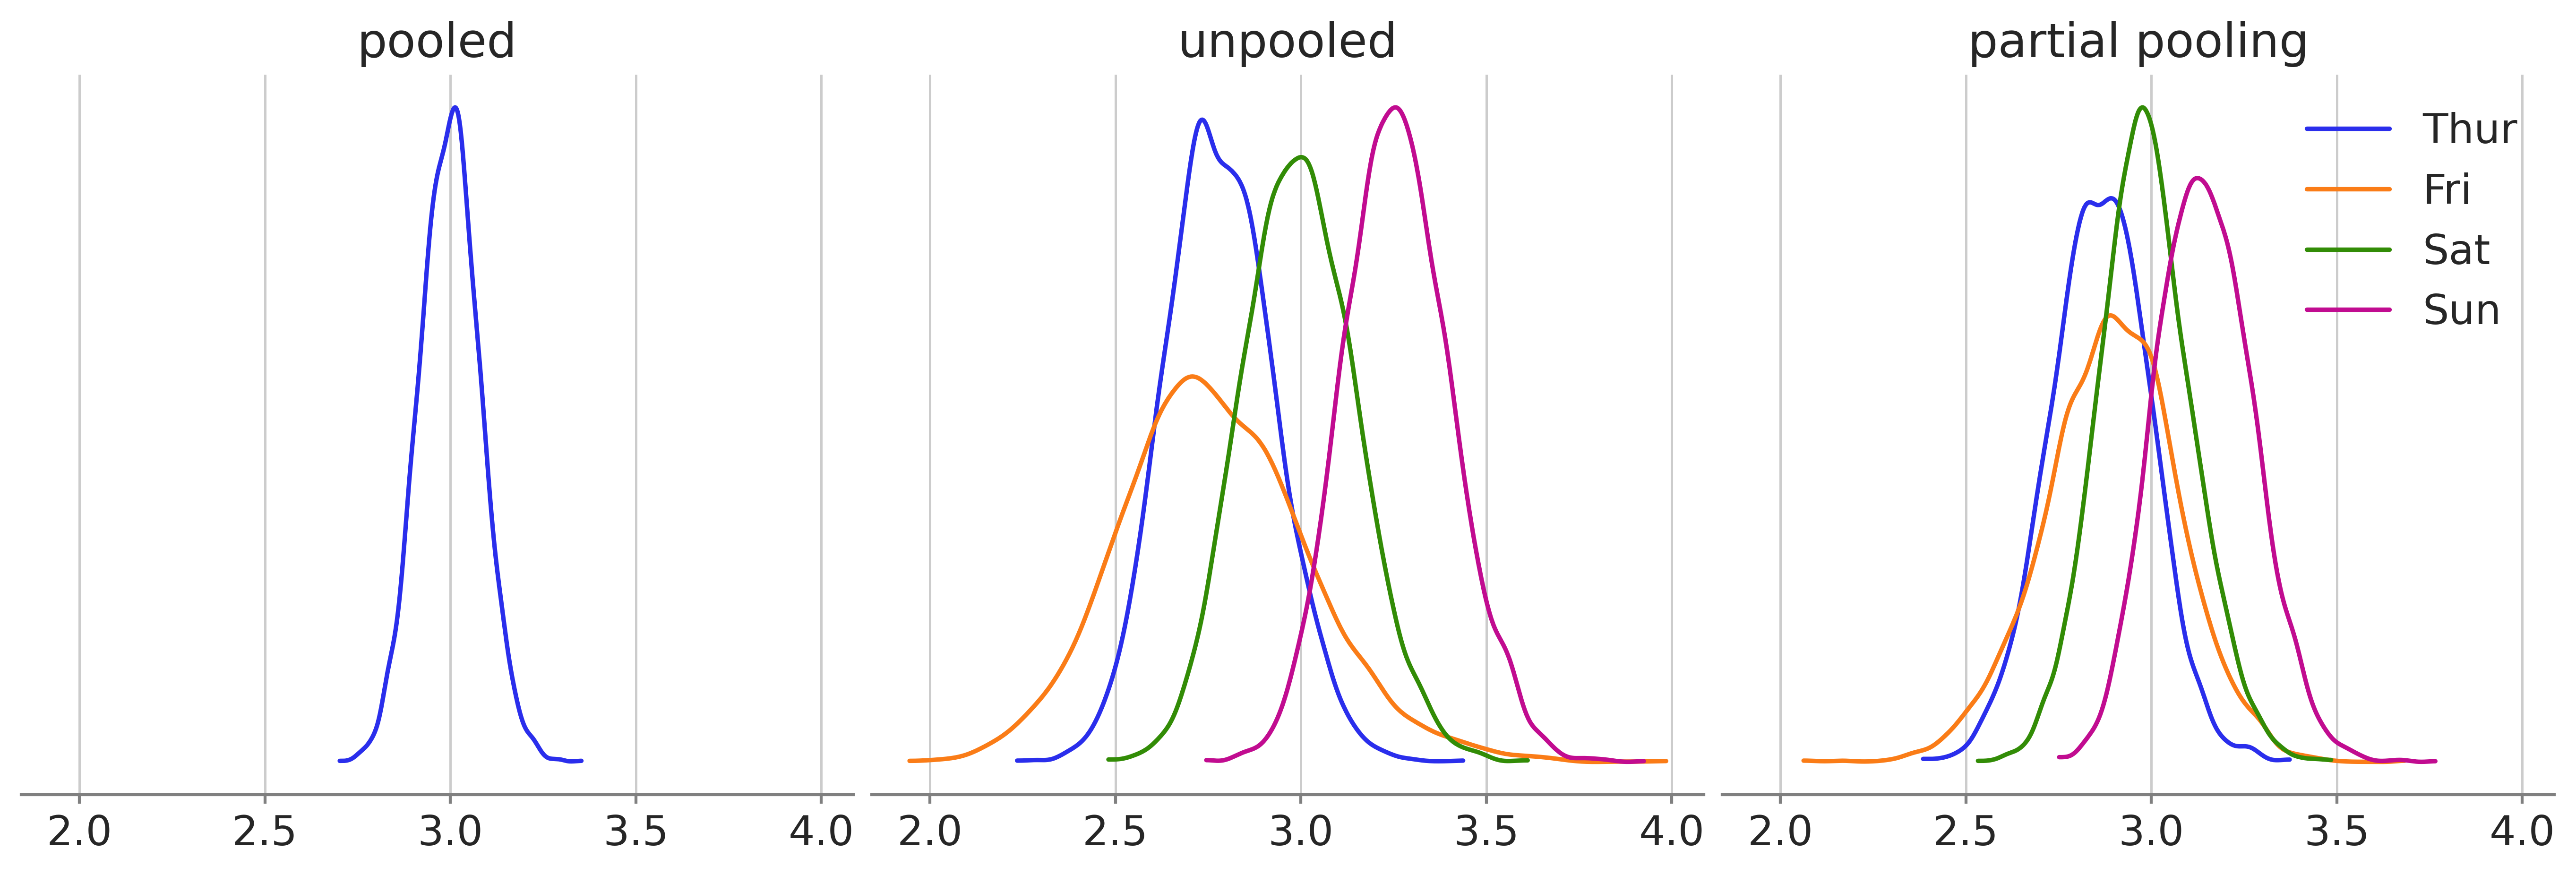

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
for i, (model_name, idata) in enumerate(idatas.items()):
    if model_name == "pooled":
        pm.plot_posterior(idata, var_names=["μ", "σ"], ax=ax[i], hdi_prob='hide', point_estimate=None)
    else:
        for j,day in enumerate(categories):
            pm.plot_posterior(idata, var_names=["μ", "σ"], hdi_prob='hide', point_estimate=None,
                              color=f"C{j}", coords={"days": day}, label=f'{day}', 
                              ax=ax[i])
    ax[i].set_title(model_name)
ax[1].get_legend().remove()
ax[2].legend()
plt.show()

array([<Axes: >], dtype=object)

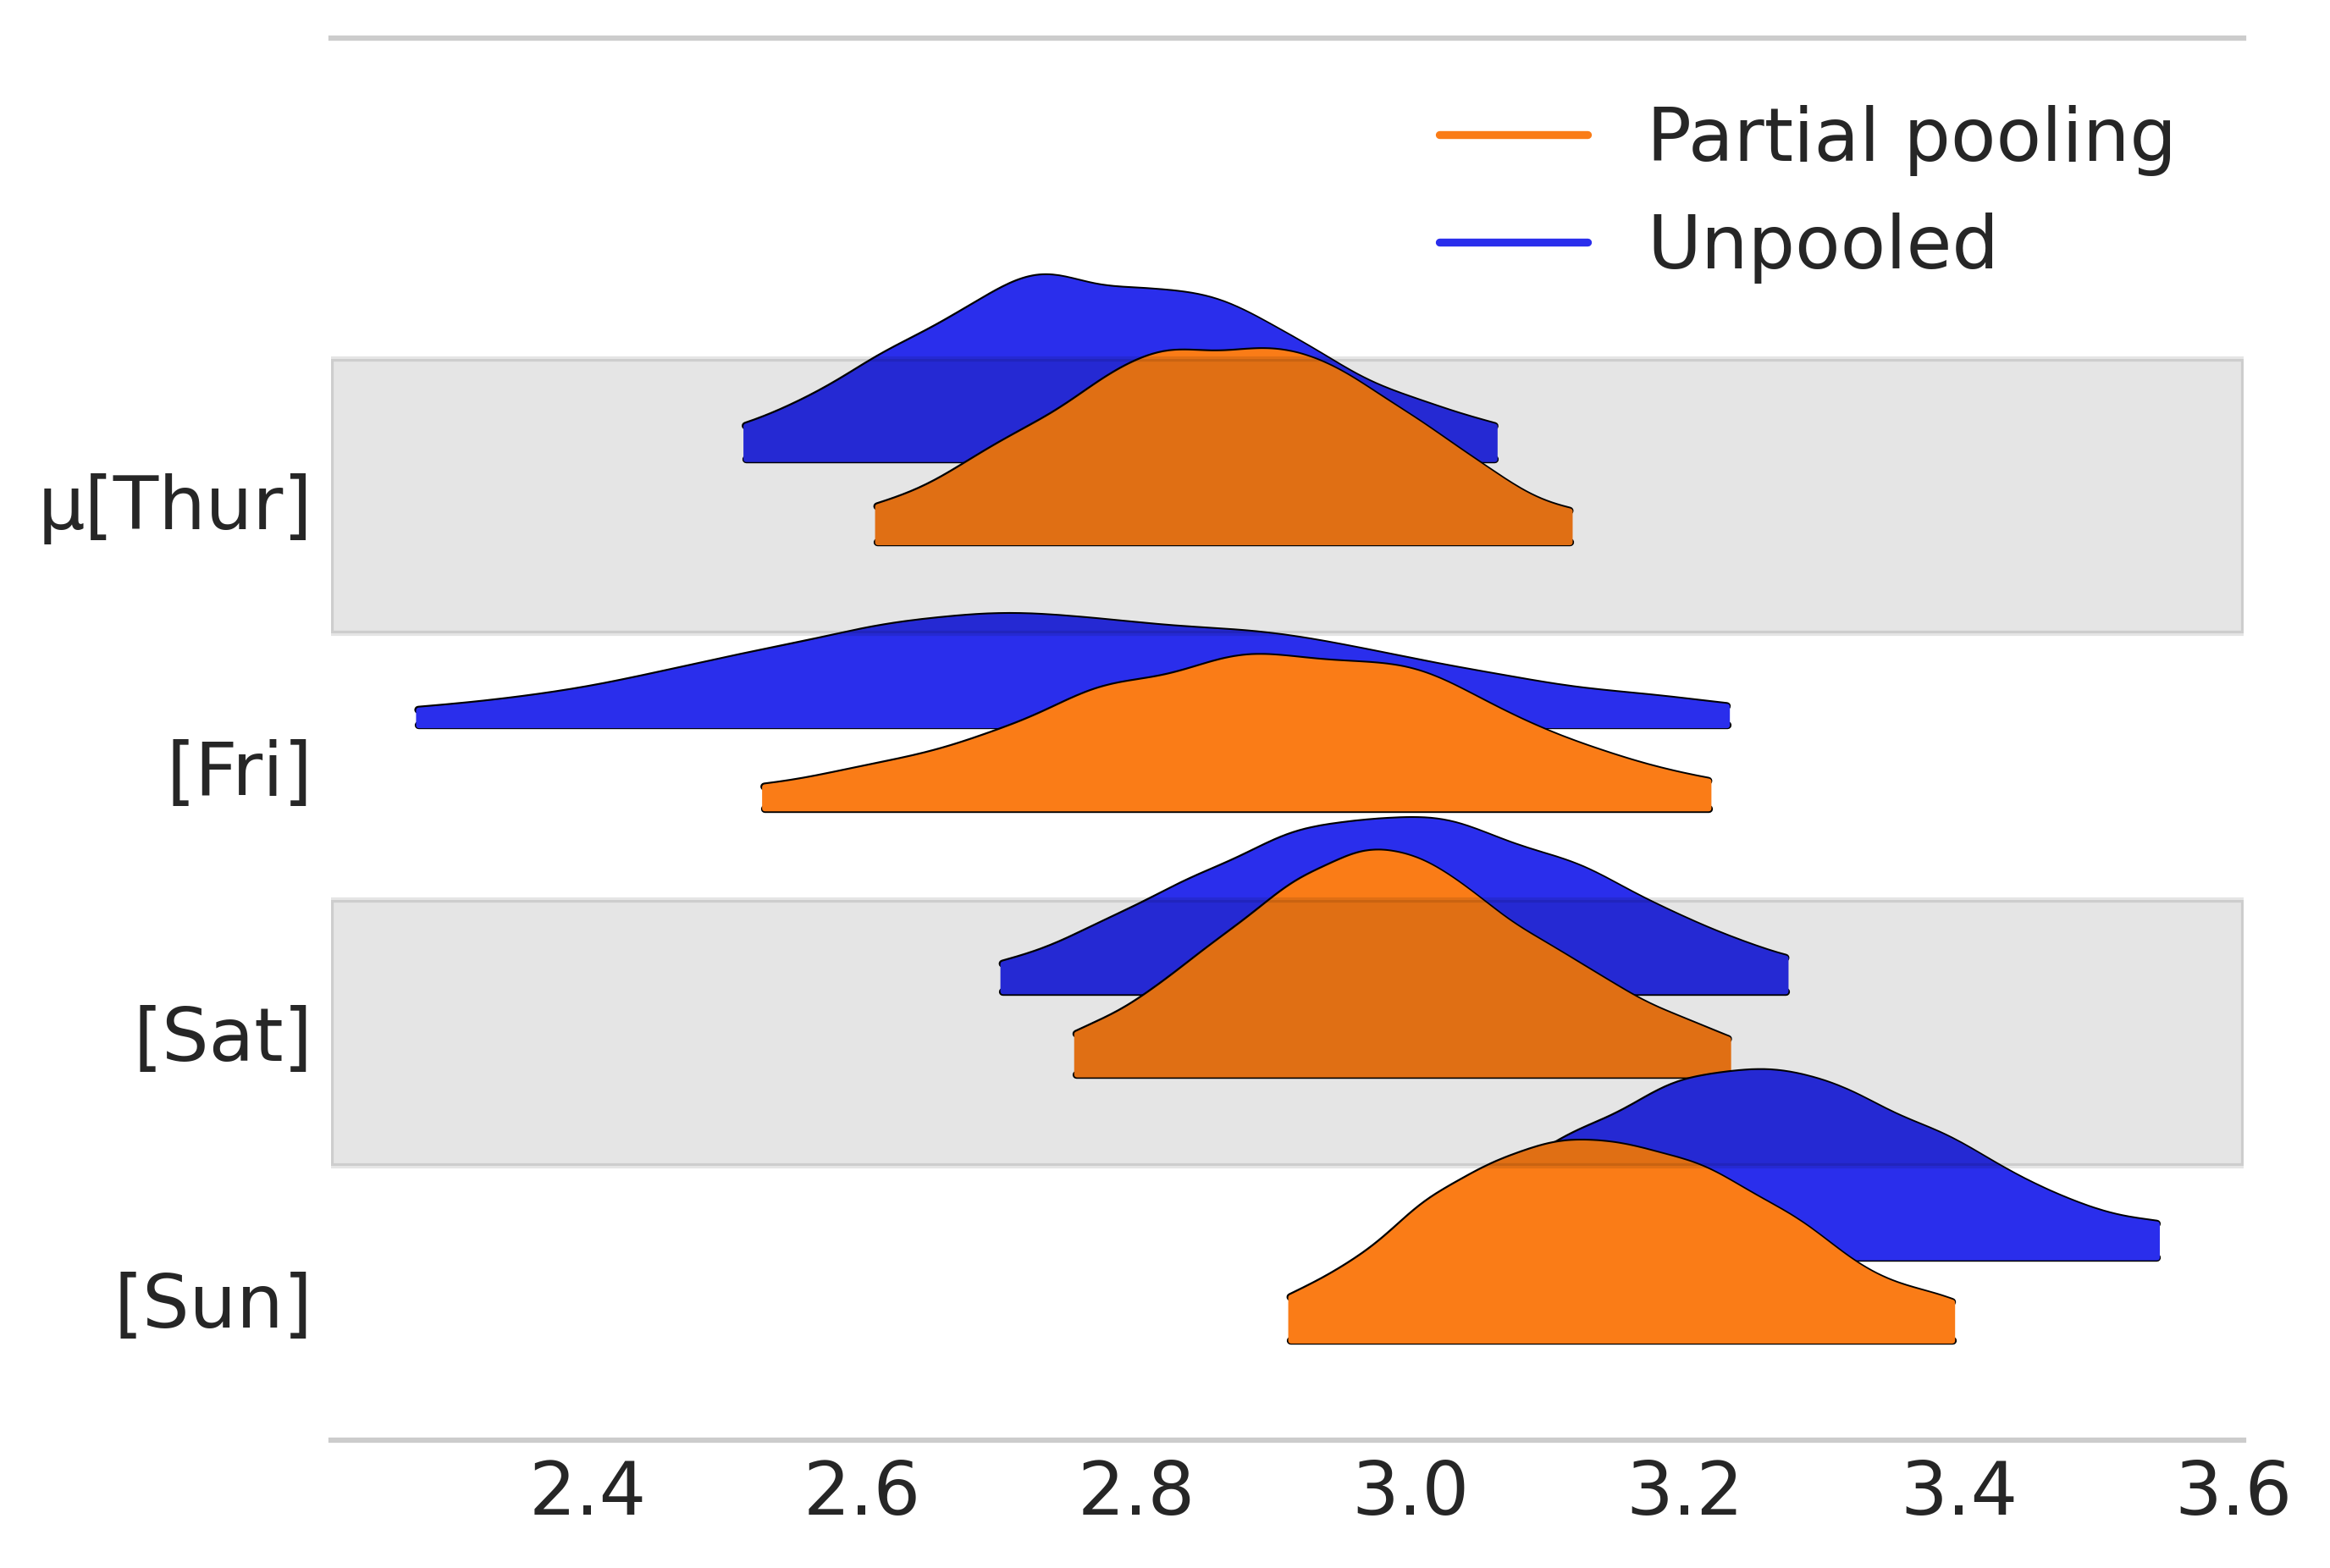

In [61]:
az.plot_forest([idatas["unpooled"], idatas["partial pooling"]], 
               var_names="μ", model_names=["Unpooled", "Partial pooling"], 
               kind="ridgeplot",
               combined=True, figsize=(6, 4))

In [62]:
cs_data = pd.read_csv('https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [63]:
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [64]:
μ_μ = 0
σ_μ = 10
σ_σ = 10

with pm.Model(coords=coords) as cs_p:         
    μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ) 
    σ = pm.HalfNormal('σ', sigma=σ_σ) 
 
    y = pm.Normal('y', mu=μ, sigma=σ, observed=diff) 
     
    

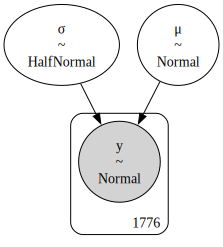

In [65]:
pm.model_to_graphviz(cs_p)

In [66]:
idata_cs_p = pm.sample(random_seed=4591, model=cs_p)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [67]:
μ_μ = 0
σ_μ = 10
σ_σ = 10

with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=σ_σ, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    

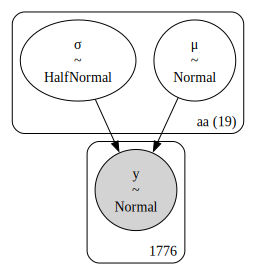

In [68]:
pm.model_to_graphviz(cs_nh)

In [69]:
idata_cs_nh = pm.sample(random_seed=4591, model=cs_nh)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [70]:

μ_μμ = 0
σ_μμ = 10
σ_σμ = 10

with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=μ_μμ, sigma=σ_μμ)
    σ_μ = pm.HalfNormal('σ_μ', σ_σμ)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    

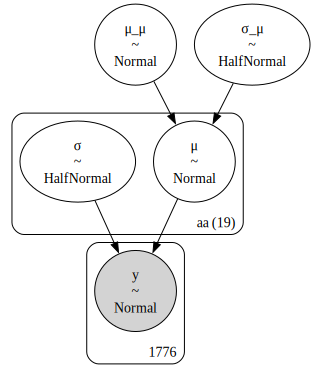

In [71]:
pm.model_to_graphviz(cs_h)

In [72]:
idata_cs_h = pm.sample(random_seed=4591, model=cs_h)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_μ, σ_μ, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


In [73]:
idata_cs_h

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [75]:
idata_cs_h.posterior["aa"]

<xarray.DataArray 'aa' (aa: 19)> Size: 228B
array(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
      dtype='<U3')
Coordinates:
  * aa       (aa) <U3 228B 'ALA' 'ARG' 'ASN' 'ASP' ... 'THR' 'TRP' 'TYR' 'VAL'

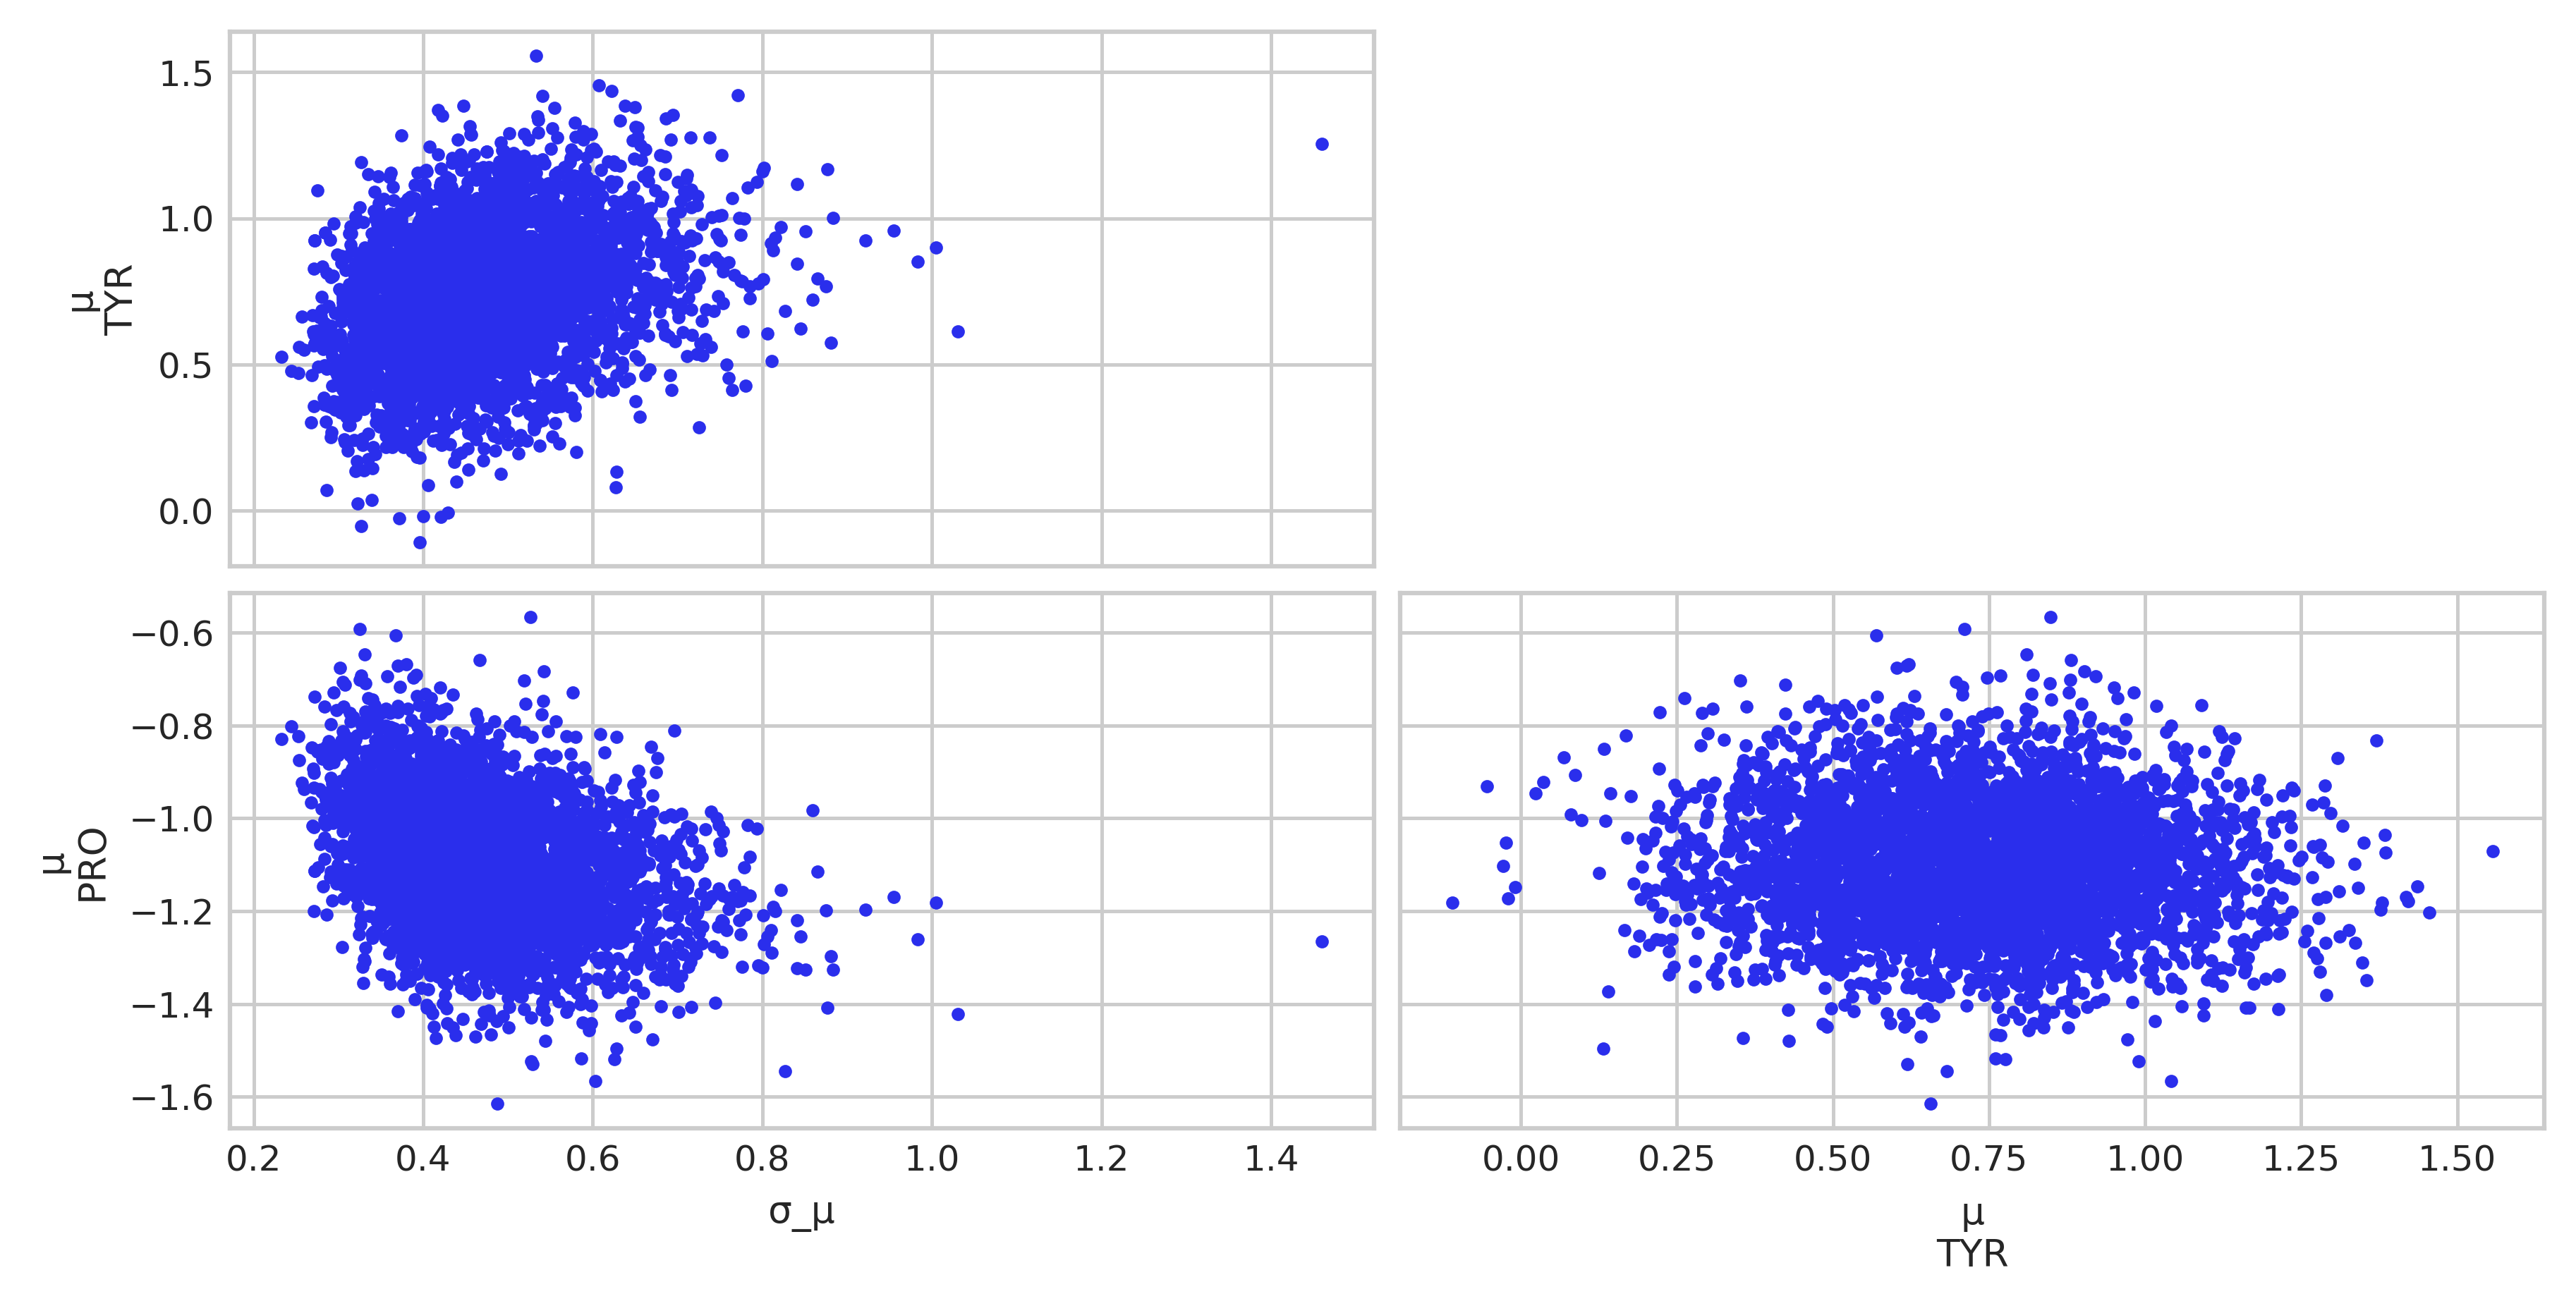

In [83]:
ax = az.plot_pair(idata_cs_h, var_names=["σ_μ", "μ"], coords={"aa": ["TYR", "PRO"]}, 
             kind="scatter", marginals=False, figsize=(8, 4), textsize=8)


Text(0.5, 1.0, '$σ_μ$ and $\\text{std}({μ_{aa}})$')

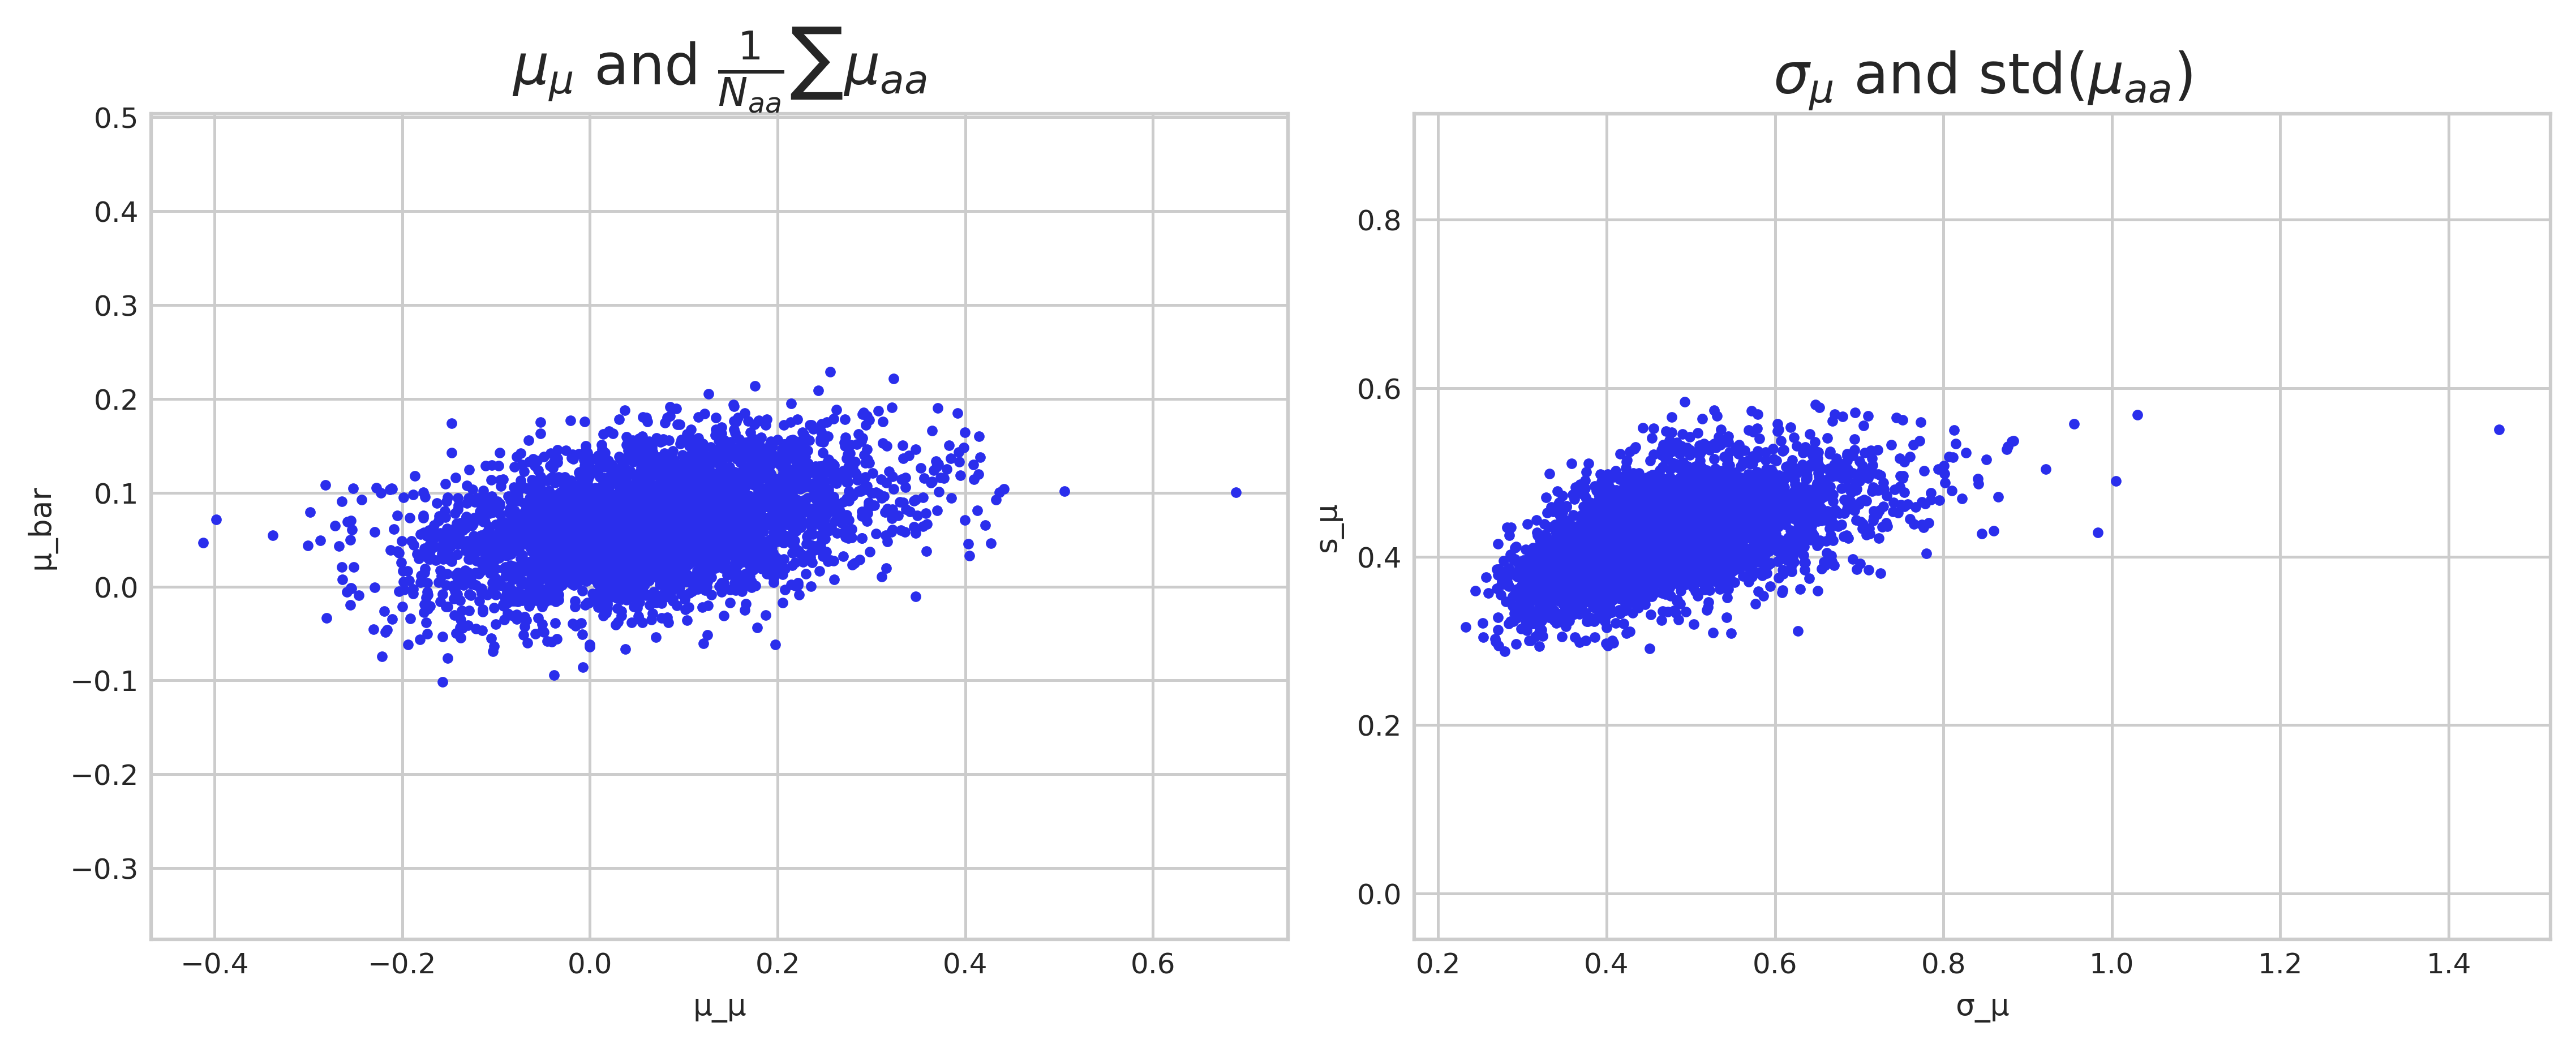

In [98]:
idata_cs_h.posterior["μ_bar"] = idata_cs_h.posterior["μ"].mean(dim="aa")
idata_cs_h.posterior["s_μ"] = idata_cs_h.posterior["μ"].std(dim="aa")

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)
az.plot_pair(idata_cs_h, var_names=["μ_μ", "μ_bar"], kind="scatter", 
             marginals=False, figsize=(8, 4), textsize=8, ax=ax[0])
ax[0].axis('equal')
ax[0].set_title(r"$μ_μ$ and $\frac{1}{N_{aa}}\sum{μ_{aa}}$")

az.plot_pair(idata_cs_h, var_names=["σ_μ", "s_μ"], kind="scatter", 
             marginals=False, figsize=(8, 4), textsize=8, ax=ax[1])
ax[1].axis('equal')
ax[1].set_title(r"$σ_μ$ and $\text{std}({μ_{aa}})$")